# SimpleNet

In [2]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.7 MB/s eta 0:00:00


In [3]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=ad981e4cb4a086c25a8a311917ae2416ef3b1d2423538dca6146d3b479e46e3b
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from medmnist import RetinaMNIST
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize
from monai.networks.blocks import MLPBlock

from sklearn.metrics import confusion_matrix
import seaborn as sns

## Load Dataset

In [5]:
# Load RetinaMNIST dataset
def get_retina_mnist_data(split, transform=None):
    return RetinaMNIST(split=split, transform=transform, download=True, as_rgb=True)

# Transforms
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Load train and validation splits
train_dataset = get_retina_mnist_data("train", transform)
val_dataset = get_retina_mnist_data("val", transform)

100%|██████████| 3.29M/3.29M [00:05<00:00, 612kB/s]


Using downloaded and verified file: /root/.medmnist/retinamnist.npz


In [5]:
# Load RetinaMNIST dataset
def get_retina_mnist_data(split, transform=None):
    return RetinaMNIST(split=split, transform=transform, download=True, as_rgb=True)

# Transforms
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Load train and validation splits
train_dataset = get_retina_mnist_data("train", transform)
val_dataset = get_retina_mnist_data("val", transform)

Using downloaded and verified file: /root/.medmnist/retinamnist.npz
Using downloaded and verified file: /root/.medmnist/retinamnist.npz


## Define Model

In [6]:
# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class SimpleNet(nn.Module):
    # initialize model
    def __init__(self, input_size, num_classes):
        super(SimpleNet, self).__init__()
        # define layers of neural net
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU() # ReLU activation function to introduce non-linearity
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the input tensor
        x = self.relu(self.fc1(x)) # pass the input through the first layer, followed by the ReLU activation
        return self.fc2(x) # pass the result through the second fully connected layer and return the output

# Initialize model
input_size = 3 * 28 * 28  # RetinaMNIST image dimensions (3 channels, 28x28 pixels)
num_classes = 5           # 5 severity levels for diabetic retinopathy
model = SimpleNet(input_size=input_size, num_classes=num_classes)

In [7]:
criterion = nn.CrossEntropyLoss()  # For ordinal regression, replace as needed
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20
train_acc = []

## Train

Epoch 1/200, Loss: 1.3871, Accuracy: 43.15%
Epoch 2/200, Loss: 1.2495, Accuracy: 47.69%
Epoch 3/200, Loss: 1.1931, Accuracy: 50.19%
Epoch 4/200, Loss: 1.1993, Accuracy: 49.17%
Epoch 5/200, Loss: 1.1736, Accuracy: 50.56%
Epoch 6/200, Loss: 1.1660, Accuracy: 50.65%
Epoch 7/200, Loss: 1.1495, Accuracy: 51.48%
Epoch 8/200, Loss: 1.1885, Accuracy: 49.54%
Epoch 9/200, Loss: 1.1586, Accuracy: 52.04%
Epoch 10/200, Loss: 1.1341, Accuracy: 51.30%
Epoch 11/200, Loss: 1.1739, Accuracy: 51.11%
Epoch 12/200, Loss: 1.1239, Accuracy: 52.59%
Epoch 13/200, Loss: 1.1233, Accuracy: 51.57%
Epoch 14/200, Loss: 1.1623, Accuracy: 51.20%
Epoch 15/200, Loss: 1.1173, Accuracy: 54.07%
Epoch 16/200, Loss: 1.1138, Accuracy: 53.70%
Epoch 17/200, Loss: 1.1217, Accuracy: 52.96%
Epoch 18/200, Loss: 1.0948, Accuracy: 55.28%
Epoch 19/200, Loss: 1.1061, Accuracy: 52.22%
Epoch 20/200, Loss: 1.1142, Accuracy: 53.61%
Epoch 21/200, Loss: 1.0998, Accuracy: 54.91%
Epoch 22/200, Loss: 1.0940, Accuracy: 52.59%
Epoch 23/200, Loss:

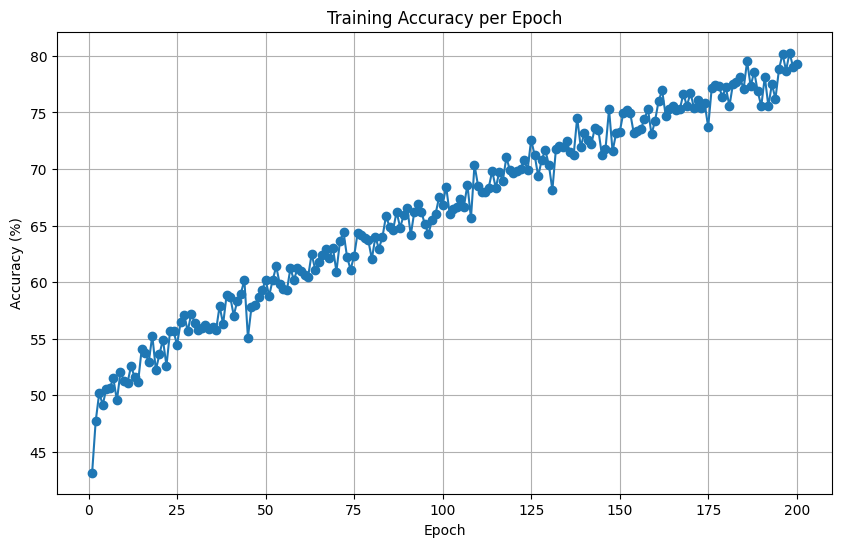

In [8]:
num_epochs = 200 #THIS SHOULD BE ~2000 just keeping low while I debug
train_acc = []

for epoch in range(num_epochs):
    model.train() # set model to training mode
    # initialize variables to track the loss and accuracy during training
    running_loss = 0.0
    correct = 0
    total = 0
    # loop through the entire training dataset
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.squeeze().to(device)

        optimizer.zero_grad() # zero the gradients for the optimizer
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, labels) # calculate the loss
        loss.backward() #backward pass
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # get the predicted class by selecting the class with the highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_acc.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

# Plot Training Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_acc, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy per Epoch")
plt.grid()
plt.show()

## Display Example Predictions

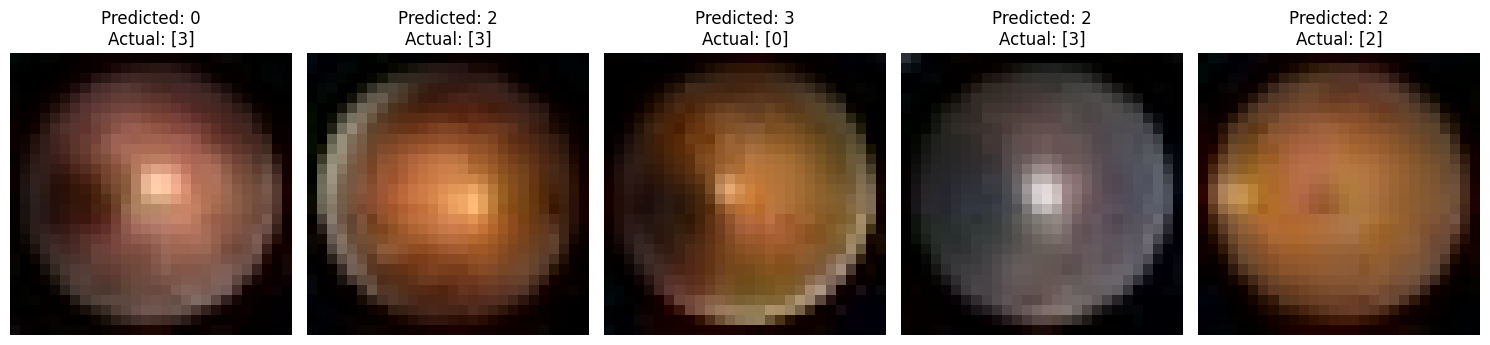

In [9]:
import random
import matplotlib.pyplot as plt

# Function to display random samples with predictions and actual labels
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    samples = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    # loop over each randomly selected sample index
    for i, idx in enumerate(samples):
        image, label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        with torch.no_grad():
            output = model(image_tensor)
            predicted_label = torch.argmax(output, 1).item()

        # move the image back to CPU for visualization
        image = image.permute(1, 2, 0).cpu().numpy()
        image = (image * 0.5) + 0.5  # undo normalization for visualization
        # plot the image on the corresponding axis
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Predicted: {predicted_label}\nActual: {label}")

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, val_dataset, num_samples=5)

## Confusion Matrix

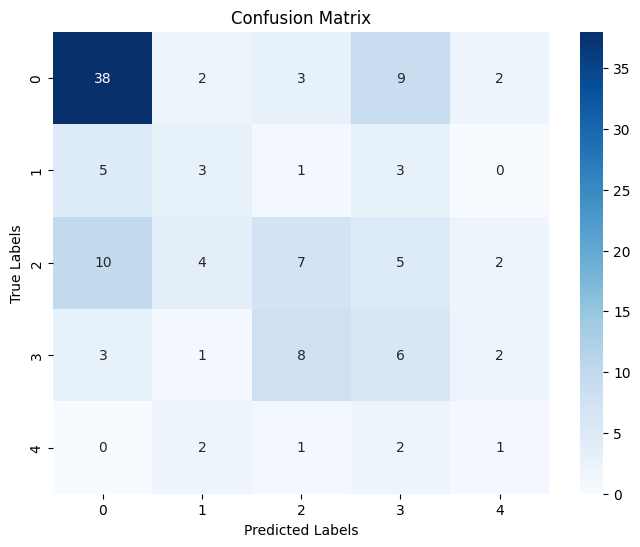

In [10]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Function to generate confusion matrix
def generate_confusion_matrix(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No need to track gradients during inference
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            all_labels.extend(labels.cpu().numpy())  # Store true labels
            all_preds.extend(predicted.cpu().numpy())  # Store predicted labels

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Define the class names (adjust if necessary based on your dataset)
    class_names = [str(i) for i in range(5)]  # Assuming 5 classes (0 to 4)

    # Plot confusion matrix
    plot_confusion_matrix(cm, class_names)

generate_confusion_matrix(model, val_loader)

## Generate Saliency

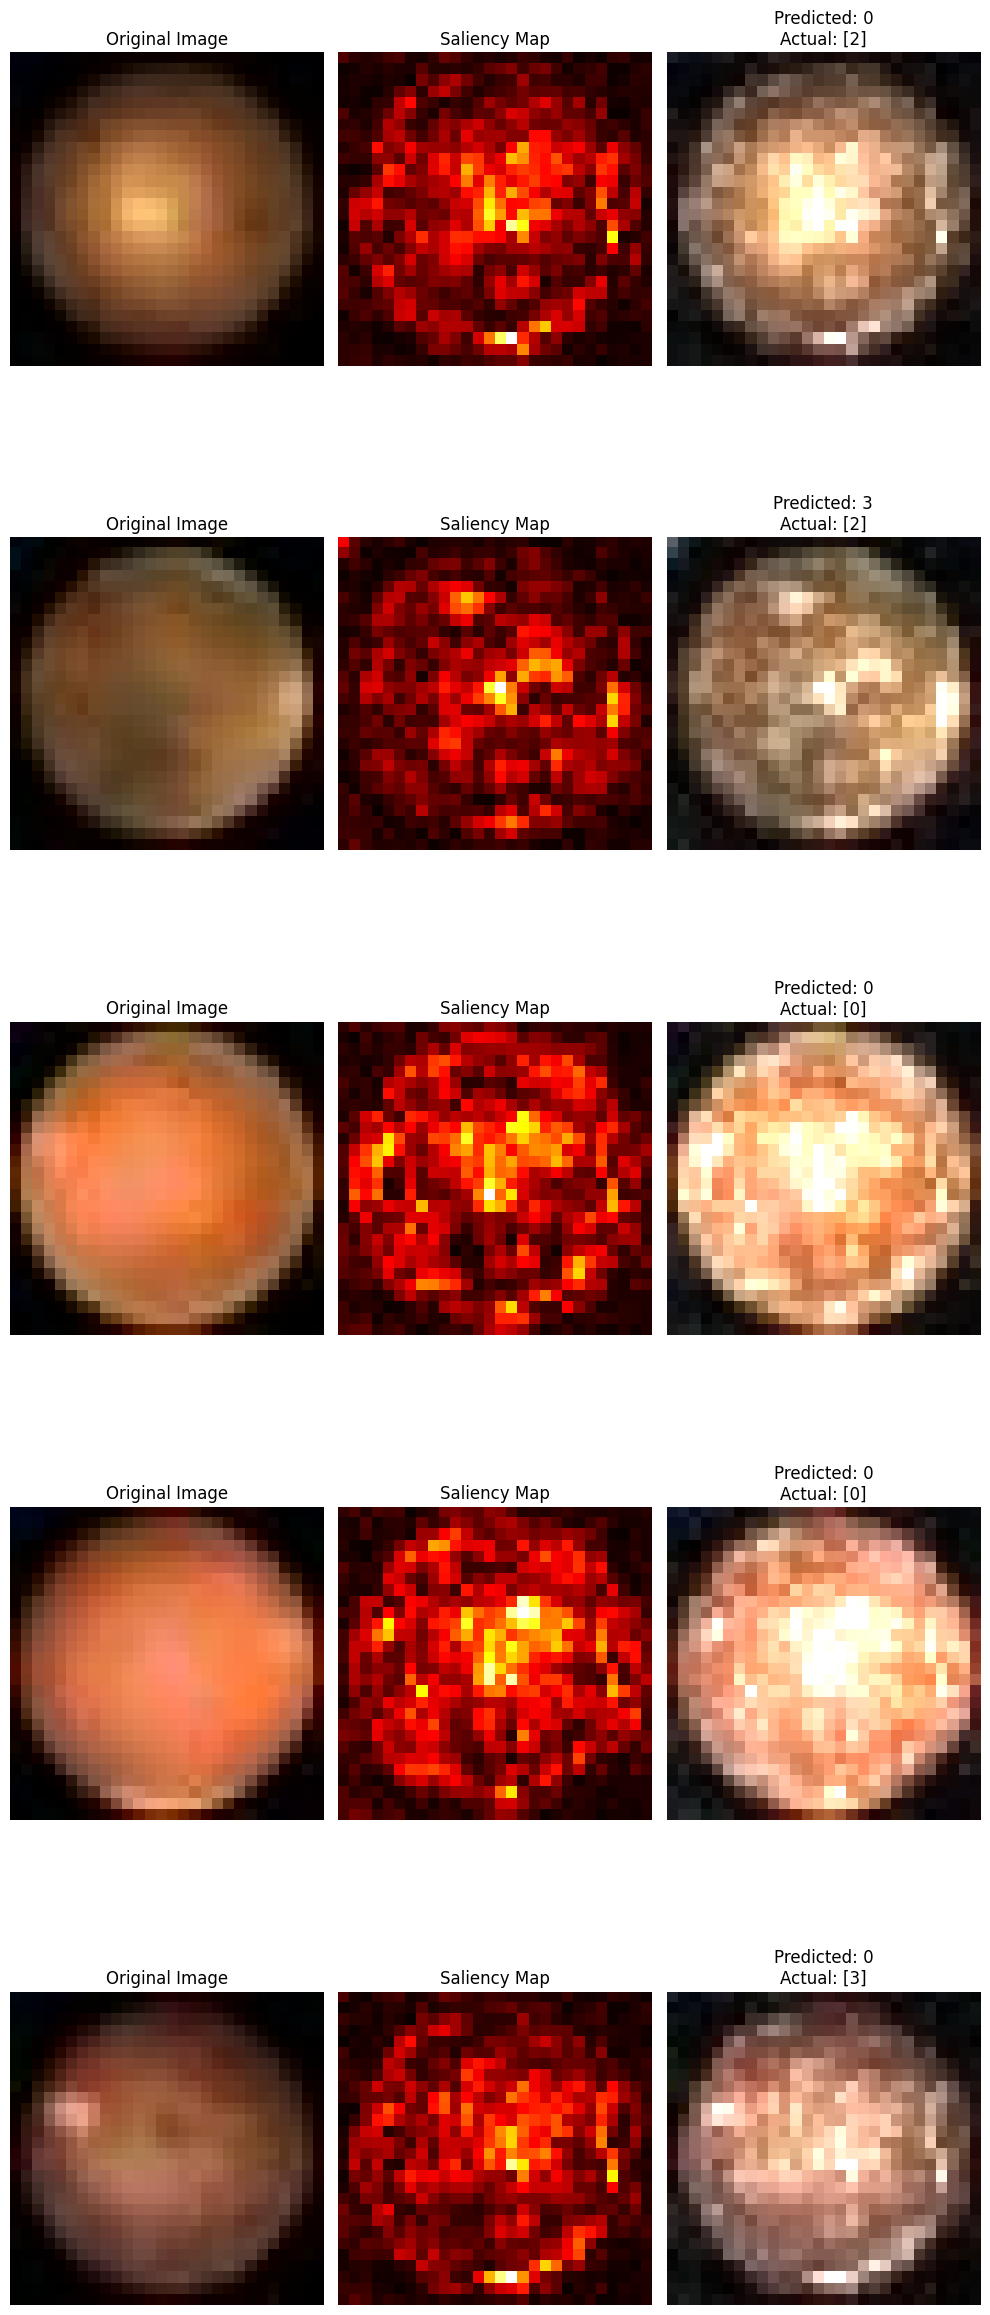

In [11]:
#entire code regenerated with gradcam included NOT WORKING

def visualize_saliency(model, dataset, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    samples = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))

    for i, idx in enumerate(samples):
        image, label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Flatten the input to match the model's expectation
        image_tensor = image_tensor.view(image_tensor.size(0), -1)
        image_tensor.requires_grad_()

        # Get model prediction
        output = model(image_tensor)
        predicted_label = torch.argmax(output, 1).item()

        # Compute gradients of the output w.r.t the input
        model.zero_grad()
        output[0, predicted_label].backward()
        saliency = image_tensor.grad.abs().squeeze().cpu().numpy()

        # Reshape the saliency map back to the original image shape
        saliency = saliency.reshape(3, 28, 28).max(axis=0)  # Take the maximum across channels
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  # Normalize

        # Undo normalization for the original image
        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np * 0.5) + 0.5  # Undo normalization

        # Overlay saliency map on the image
        overlay = np.clip(image_np + np.expand_dims(saliency, axis=-1), 0, 1)

        # Plot the original image, saliency map, and overlay
        axes[i, 0].imshow(image_np)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Original Image")

        axes[i, 1].imshow(saliency, cmap="hot")
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Saliency Map")

        axes[i, 2].imshow(overlay)
        axes[i, 2].axis("off")
        axes[i, 2].set_title(f"Predicted: {predicted_label}\nActual: {label}")

    plt.tight_layout()
    plt.show()

visualize_saliency(model, val_dataset, num_samples=5)


